In [ ]:
import torch
from collections import OrderedDict
from torch import nn
from torch.utils.data.dataset import Dataset  # For custom data-sets
from torchvision import transforms
from PIL import Image
import os.path as osp
from os import mkdir
import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "gdrive/My Drive/NSU-DNN_Course/Lab2/sticks"

[Errno 2] No such file or directory: 'gdrive/My Drive/NSU-DNN_Course/Lab2/'
/content/gdrive/My Drive/NSU-DNN_Course/Lab2


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# FSRCNN - сеть повышения разрешения изображений
Оригинальная статья: https://arxiv.org/pdf/1608.00367.pdf  
Глава 3.2 описывает реализацию сети, попробуем повторить ее

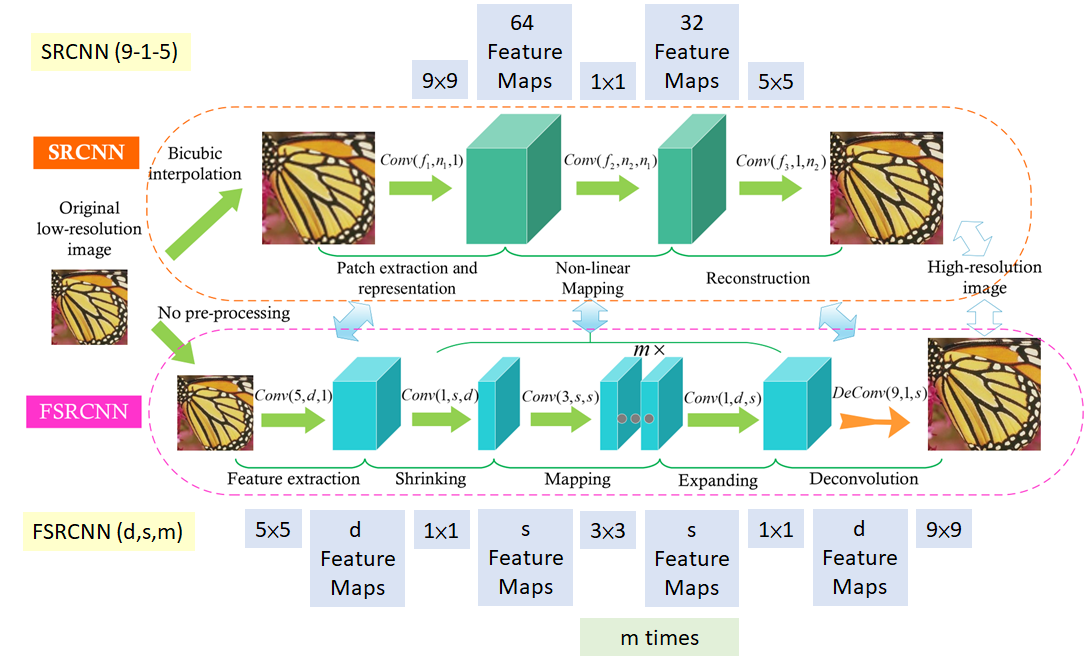

In [ ]:
class FSRCNN(nn.Module):
    def __init__(self, num_channels, scale_factor, pretrained_weights=None):
        super(FSRCNN, self).__init__()
        # Гиперпараметры модели
        '''
          Вообще, сетка немного отличается от оригинальной - я решила попробовать обучиться на RGB снимках, а не на чёрно-белых,
          поэтому я решила увеличить количество обучаемых ядер свёртки для трехканальных снимков в 3 раза.
        ''' 
        d = 56 * num_channels   # Кол-во выходных слоев из свёрточного слоя блока 'Feature extraction layer'
        s = 12 * num_channels   # Кол-во выходных слоев из свёрточного слоя блока 'Shrinking layer' и 'Mapping layer'

        m = 6
        ''' 
                    Количество свёрточных слоев в блоке "Mapping layer"
                    Определяет как точность, так и сложность отображения
        '''
                    # Да, в статье это layer, я же буду называть это блоком слоев, ы

        ''' Сначала все описывала через nn.Sequential, пока не дошла до блока 'Mapping layer', 
            В котором число свёрток варьируется, по итогу перешла на nn.OrderedDict,
            который упоминался в документации к nn.Sequential
        '''
        
        i_conv = 1
        
        # Feature extraction layer
        self.feature_extraction_layer = nn.Sequential(
            OrderedDict([
                (
                    f"conv{i_conv}", 
                    nn.Conv2d(
                        in_channels=num_channels, out_channels=d,  
                        kernel_size=(5, 5),
                        stride=(1, 1), padding=(2, 2), padding_mode='zeros', # Сохраняем размерность входа
                        bias=True
                    )
                ), (
                    f"prelu{i_conv}", nn.PReLU(num_parameters=d, init=0) # По сути, изначально это ReLu
                )
            ]) 
        )
        i_conv += 1
        
        # Shrinking layer # Уменьшаем кол-во параметров 
        self.shrinking_layer = nn.Sequential(
            OrderedDict([
                (
                    f"conv{i_conv}", 
                    nn.Conv2d(
                        in_channels=d, out_channels=s,
                        kernel_size=(1, 1),
                        stride=(1, 1), padding=(0, 0), 
                        bias=True
                    )
                ), (f"prelu{i_conv}", nn.PReLU(num_parameters=s, init=0)) 
            ])
        )
        i_conv += 1

        # Non-linear mapping layer
        mapping_layer_list =  []
        for i in range(m):
            mapping_layer_list.append((
                f"conv{i_conv}", 
                nn.Conv2d(
                    in_channels=s, out_channels=s,
                    kernel_size=(3, 3), 
                    stride=(1, 1), padding=(1, 1), padding_mode='zeros',
                    bias=True
                )
            ))
            mapping_layer_list.append((f"prelu{i_conv}", nn.PReLU(num_parameters=s, init=0)))
            i_conv += 1
        
        self.mapping_layer = nn.Sequential(OrderedDict(mapping_layer_list))
        # Пишем и надеемся, что сработает

        # Expanding layer  # Блок, противоположный по назначению shrinking блоку
        self.expanding_layer = nn.Sequential(
            OrderedDict([
                (
                    f"conv{i_conv}", 
                    nn.Conv2d(
                        in_channels=s, out_channels=d,  
                        kernel_size=(1, 1),
                        stride=(1, 1), padding=(0, 0), 
                        bias=True
                    )
                ), (f"prelu{i_conv}", nn.PReLU(num_parameters=d, init=0))
            ]) 
        )
        i_conv += 1

        # Deconvolution layer
        self.deconv_layer = nn.Sequential(
            OrderedDict([(
                f"deconv{i_conv}",
                nn.ConvTranspose2d(
                    in_channels = d, out_channels = num_channels, 
                    kernel_size = (9, 9),
                    stride=(scale_factor, scale_factor),
                    padding=(4, 4),
                    output_padding = (scale_factor - 1, scale_factor - 1), 
                    bias=True, 
                    padding_mode='zeros'
                ) 
            )])
            # Мне очень не нравится эта реализация повышения разрешения, особенно из-за того, что пришлось добавлять паддинг на выходном снимке
            # Я бы предпочла subpixelconv- https://www.programmersought.com/article/97116040558/
        )


    def forward(self, x):
        out = self.feature_extraction_layer(x)
        out = self.shrinking_layer(out)
        out = self.mapping_layer(out)
        out = self.expanding_layer(out)
        out = self.deconv_layer(out)

        return out

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, loss, metric, i_epoch, epochs):
    # До этого определили размер батча для train_dataloader
    # Теперь надо пройти по всем батчам картинок для обучения одной эпохи 
    batches = len(train_dataloader)
    total_loss_value = 0.0
    total_metric_value = 0.0

    for index, (LR_images, HR_images) in enumerate(train_dataloader):
        LR_images = LR_images.to(device)
        HR_images = HR_images.to(device)

        optimizer.zero_grad()
        # На самом деле такие снимки неправильно называть суперразрешенными, 
        # так как используется только одно представление LR для генерации сопоставимого с HR снимка, ну да ладно
        SR_images = model.forward(LR_images) 
        loss_value = loss(SR_images,HR_images)
        total_loss_value += loss_value.item()
        loss_value.backward()
        optimizer.step()

        metric_value = metric(SR_images, HR_images)
        total_metric_value += metric_value.item()
        if (index + 1) % 5 == 0:
            print(
                f"(Epoch {i_epoch + 1}/{epochs}-{index + 1}/{batches})\t", 
                f"Loss: {loss_value.item():.6f}\t", 
                f"Metric: {metric_value.item():.6f}", sep=''
            )
    total_loss_value /= batches
    total_metric_value /= batches
    print(
        f"Resulrts model training for epoch {i_epoch + 1}/{epochs}:\n\t",
        f"Loss\t: {total_loss_value:.6f}\t", 
        f"Metric\t: {total_metric_value:.6f}", sep='', end='\n'
    )
    return total_loss_value, total_metric_value

In [ ]:
def validate(model, valid_dataloader, loss, metric):
    batches = len(valid_dataloader)
    total_val_loss_value = 0.0
    total_val_metric_value = 0.0
    with torch.no_grad():
        for index, (LR_images, HR_images) in enumerate(valid_dataloader):
            LR_images = LR_images.to(device)
            HR_images = HR_images.to(device)
            SR_images = model(LR_images)           
            total_val_loss_value += loss(SR_images, HR_images).item()
            total_val_metric_value += metric(SR_images, HR_images).item()

        total_val_loss_value /= batches
        total_val_metric_value /= batches
        print(
            f'\tLoss val: {total_val_loss_value:.6f}\t', 
            f'Metric val: {total_val_metric_value:.6f}', sep=''
        )
        return total_val_loss_value, total_val_metric_value

# Подготовка данных

Набор LR снимков был сгенерирован из HR изображений посредством линейной интерполяции со scale=1/2 + Гауусова размытия ядром (5, 5).  
Все снимки представлены как RGB, но их не так много, так что также протестируем  и модель для чёрно-белых снимков.

In [ ]:
%ls

512x512/  checkpoints/  FSRCNN.ipynb


In [ ]:
image_size = 512

https://stackoverflow.com/questions/64458201/image-mask-pair-do-not-match-one-another-in-a-semantic-segmentation-task

Если не отсортировать массивы - LR и HR не являются сопоставимыми 

In [ ]:
LR_s2_train_paths = sorted(glob.glob(osp.join(".", f"{image_size}x{image_size}", "train", "LR_linear_2", "*.jpg")))
HR_train_paths = sorted(glob.glob(osp.join(".", f"{image_size}x{image_size}", "train", "HR", "*.jpg")))

LR_s2_validate_paths = sorted(glob.glob(osp.join(".", f"{image_size}x{image_size}", "validate", "LR_linear_2", "*.jpg")))
HR_validate_paths = sorted(glob.glob(osp.join(".", f"{image_size}x{image_size}", "validate", "HR", "*.jpg")))

LR_s2_test_paths =  sorted(glob.glob(osp.join(".", f"{image_size}x{image_size}", "test", "LR_linear_2", "*.jpg")))
HR_test_paths = sorted(glob.glob(osp.join(".", f"{image_size}x{image_size}", "test", "HR", "*.jpg")))

In [ ]:
#LR_s2_test_paths

In [ ]:
# HR_stest_paths

In [ ]:
def preprocess_image(image_pil):
    image_np = np.array(image_pil, dtype=np.float32)
    image_np =  image_np/ 255.0
    # Формат изображения в PIL - Channels Last ([Количество картинок в батче; Высота; Ширина; Количество каналов])
    # Перейдем к формату - Chennels First посредством изменения порядка измерений
    image_np = np.transpose(image_np, [2, 0, 1]) 
    return torch.from_numpy(image_np)

In [ ]:
class LR_HR_Dataset(Dataset):
    def __init__(self, LR_paths, HR_paths, train=True):
        self.LR_paths = LR_paths
        self.HR_paths = HR_paths
        self.transforms = lambda image: preprocess_image(image)

    def __getitem__(self, index):
        LR = self.transforms(Image.open(self.LR_paths[index]))
        HR = self.transforms(Image.open(self.HR_paths[index]))
        return LR, HR

    def __len__(self):
        return len(self.LR_paths)

In [ ]:
rgb_s2_train_dataset = LR_HR_Dataset(LR_s2_train_paths, HR_train_paths, train=True)
rgb_s2_train_loader = torch.utils.data.DataLoader(rgb_s2_train_dataset, batch_size=5, shuffle=True, num_workers=1)

rgb_s2_test_dataset = LR_HR_Dataset(LR_s2_test_paths, HR_test_paths, train=False)
rgb_s2_test_loader = torch.utils.data.DataLoader(rgb_s2_test_dataset, batch_size=4, shuffle=True, num_workers=1)

rgb_s2_validate_dataset = LR_HR_Dataset(LR_s2_validate_paths, HR_validate_paths, train=False)
rgb_s2_validate_loader = torch.utils.data.DataLoader(rgb_s2_validate_dataset, batch_size=4, shuffle=True, num_workers=1)

Создадим dataloader  для одноканальных снимков

In [ ]:
def preprocess_image_to_grayscale(image_pil):
    image_pil = image_pil.convert('L')
    image_np = np.array(image_pil, dtype=np.float32)
    image_np =  image_np/ 255.0
    # Формат изображения в PIL - Channels Last ([Количество картинок в батче; Высота; Ширина; Количество каналов])
    # Перейдем к формату - Chennels First посредством изменения порядка измерений
    image_np = image_np[None, :, :]
    return torch.from_numpy(image_np)

In [ ]:
class LR_HR_Grayscale_Dataset(Dataset):
    def __init__(self, LR_paths, HR_paths, train=True):   # initial logic happens like transform
        self.LR_paths = LR_paths
        self.HR_paths = HR_paths
        self.transforms = lambda image: preprocess_image_to_grayscale(image)

    def __getitem__(self, index):
        LR = self.transforms(Image.open(self.LR_paths[index]))
        HR = self.transforms(Image.open(self.HR_paths[index]))
        return LR, HR

    def __len__(self):  # return count of sample we have
        return len(self.LR_paths)

In [ ]:
gray_s2_train_dataset = LR_HR_Grayscale_Dataset(LR_s2_train_paths, HR_train_paths, train=True)
gray_s2_train_loader = torch.utils.data.DataLoader(gray_s2_train_dataset, batch_size=5, shuffle=True, num_workers=1)

gray_s2_test_dataset = LR_HR_Grayscale_Dataset(LR_s2_test_paths, HR_test_paths, train=False)
gray_s2_test_loader = torch.utils.data.DataLoader(gray_s2_test_dataset, batch_size=4, shuffle=True, num_workers=1)

gray_s2_validate_dataset = LR_HR_Grayscale_Dataset(LR_s2_validate_paths, HR_validate_paths, train=False)
gray_s2_validate_loader = torch.utils.data.DataLoader(gray_s2_validate_dataset, batch_size=4, shuffle=True, num_workers=1)

# Подготовка моделей

In [ ]:
rgb_fsrcnn_s2 = FSRCNN(scale_factor=2, num_channels = 3).to(device)
gray_fsrcnn_s2 = FSRCNN(scale_factor=2, num_channels = 1).to(device)

In [ ]:
loss = nn.L1Loss(reduction = 'mean')  # MAE [0, 1] - минимизируем 
metric = lambda SR, HR: 10 * torch.log10(1 / nn.functional.mse_loss(SR, HR)) # PSNR - максимизируем - для двух одинаковых снимков оценка уходит в +inf

In [ ]:
rgb_fsrcnn_s2_optimizer = torch.optim.Adam(rgb_fsrcnn_s2.parameters(), lr=1.0e-3)
gray_fsrcnn_s2_optimizer = torch.optim.Adam(gray_fsrcnn_s2.parameters(), lr=1.0e-3)

In [ ]:
with torch.no_grad():
    for index, (LR_images, HR_images) in enumerate(rgb_s2_validate_loader):
        SR_images = rgb_fsrcnn_s2(LR_images)
        LR_images = np.transpose(LR_images, [0, 2, 3, 1])
        HR_images = np.transpose(HR_images, [0, 2, 3, 1])
        SR_images = np.transpose(SR_images, [0, 2, 3, 1])

        fig = plt.figure(figsize = (50, 120))
        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(LR_images[0])
        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(SR_images[0])
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(HR_images[0])

        if index > 5: break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with torch.no_grad():
    for index, (LR_images, HR_images) in enumerate(gray_s2_validate_loader):
        SR_images = gray_fsrcnn_s2(LR_images)
        LR_images = np.transpose(LR_images, [0, 2, 3, 1])
        HR_images = np.transpose(HR_images, [0, 2, 3, 1])
        SR_images = np.transpose(SR_images, [0, 2, 3, 1])

        fig = plt.figure(figsize = (50, 120))
        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(LR_images[0][:, :, 0], cmap='gray')
        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(SR_images[0][:, :, 0], cmap='gray')
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(HR_images[0][:, :, 0], cmap='gray')

        if index > 5: break

Output hidden; open in https://colab.research.google.com to view.

# Обучение моделей

In [ ]:
if not osp.exists(osp.join('.', 'checkpoints')):
    mkdir(osp.join('.', 'checkpoints'))

Сохраняем модель только в том случае, если значение метрики на валидациооной выборке было улучшено

## RGB scale = 2

In [ ]:
best_val_metric_value = 0.0
i_epoch_best_model = 0
epochs = 25

for i_epoch in range(0, epochs):
    total_loss_value, total_metric_value = train_one_epoch(rgb_fsrcnn_s2, rgb_s2_train_loader, rgb_fsrcnn_s2_optimizer, loss, metric, i_epoch, epochs)
    total_val_loss_value, total_val_metric_value = validate(rgb_fsrcnn_s2, rgb_s2_validate_loader, loss, metric)
    is_best = total_val_metric_value > best_val_metric_value
    if is_best:
        print(f"val_metric_value improved from {best_val_metric_value} to {total_val_metric_value}, saving model...")
        best_val_metric_value = total_val_metric_value
        i_epoch_best_model = i_epoch
        torch.save(rgb_fsrcnn_s2.state_dict(), osp.join('.', 'checkpoints', 'rgb_fsrcnn_s2.pth'))
    else:
      print(f"val_metric_value did not improve from {best_val_metric_value} on epoch {i_epoch_best_model}")

(Epoch 1/25-5/10)	Loss: 0.236193	Metric: 9.953485
(Epoch 1/25-10/10)	Loss: 0.157756	Metric: 12.060709
Resulrts model training for epoch 1/25:
	Loss	: 0.355674	Metric	: 7.805365
	Loss val: 0.177268	Metric val: 11.561622
val_metric_value improved from 0.0 to 11.561621507008871, saving model...
(Epoch 2/25-5/10)	Loss: 0.240695	Metric: 8.781202
(Epoch 2/25-10/10)	Loss: 0.149253	Metric: 11.414184
Resulrts model training for epoch 2/25:
	Loss	: 0.175916	Metric	: 10.734770
	Loss val: 0.159723	Metric val: 11.044436
val_metric_value did not improve from 11.561621507008871 on epoch 0
(Epoch 3/25-5/10)	Loss: 0.155769	Metric: 10.897354
(Epoch 3/25-10/10)	Loss: 0.186767	Metric: 9.599339
Resulrts model training for epoch 3/25:
	Loss	: 0.166730	Metric	: 10.640554
	Loss val: 0.154804	Metric val: 11.016990
val_metric_value did not improve from 11.561621507008871 on epoch 0
(Epoch 4/25-5/10)	Loss: 0.186074	Metric: 9.564974
(Epoch 4/25-10/10)	Loss: 0.168822	Metric: 10.507998
Resulrts model training for e

In [ ]:
print("Resulrts model training on test dataset:")
total_test_loss_value, total_test_metric_value = validate(rgb_fsrcnn_s2, rgb_s2_test_loader, loss, metric)

Resulrts model training on test dataset:
	Loss val: 0.038465	Metric val: 22.872281


In [ ]:
with torch.no_grad():
    for index, (LR_images, HR_images) in enumerate(rgb_s2_test_loader):
        SR_images = rgb_fsrcnn_s2(LR_images)
        LR_images = np.transpose(LR_images, [0, 2, 3, 1])
        HR_images = np.transpose(HR_images, [0, 2, 3, 1])
        SR_images = np.transpose(SR_images, [0, 2, 3, 1])

        fig = plt.figure(figsize = (50, 120))
        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(LR_images[0])
        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(SR_images[0])
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(HR_images[0])

        if index > 5: break

Output hidden; open in https://colab.research.google.com to view.

## Grayscale scale = 2

In [ ]:
best_val_metric_value = 0.0
i_epoch_best_model = 0
epochs = 25

for i_epoch in range(0, epochs):
    total_loss_value, total_metric_value = train_one_epoch(gray_fsrcnn_s2, gray_s2_train_loader, gray_fsrcnn_s2_optimizer, loss, metric, i_epoch, epochs)
    total_val_loss_value, total_val_metric_value = validate(gray_fsrcnn_s2, gray_s2_validate_loader, loss, metric)
    is_best = total_val_metric_value > best_val_metric_value
    if is_best:
        print(f"val_metric_value improved from {best_val_metric_value} to {total_val_metric_value}, saving model...")
        best_val_metric_value = total_val_metric_value
        i_epoch_best_model = i_epoch
        torch.save(gray_fsrcnn_s2.state_dict(), osp.join('.', 'checkpoints', 'gray_fsrcnn_s2.pth'))
    else:
      print(f"val_metric_value did not improve from {best_val_metric_value} on epoch {i_epoch_best_model}")

(Epoch 1/25-5/10)	Loss: 0.631809	Metric: 2.967555
(Epoch 1/25-10/10)	Loss: 0.248364	Metric: 10.120850
Resulrts model training for epoch 1/25:
	Loss	: 0.601838	Metric	: 4.137879
	Loss val: 0.224846	Metric val: 10.737661
val_metric_value improved from 0.0 to 10.737661202748617, saving model...
(Epoch 2/25-5/10)	Loss: 0.245359	Metric: 9.562610
(Epoch 2/25-10/10)	Loss: 0.162469	Metric: 12.379095
Resulrts model training for epoch 2/25:
	Loss	: 0.231475	Metric	: 9.898543
	Loss val: 0.183699	Metric val: 11.662953
val_metric_value improved from 10.737661202748617 to 11.66295337677002, saving model...
(Epoch 3/25-5/10)	Loss: 0.180329	Metric: 12.480875
(Epoch 3/25-10/10)	Loss: 0.192899	Metric: 10.628334
Resulrts model training for epoch 3/25:
	Loss	: 0.192275	Metric	: 11.499836
	Loss val: 0.168639	Metric val: 11.395290
val_metric_value did not improve from 11.66295337677002 on epoch 1
(Epoch 4/25-5/10)	Loss: 0.217855	Metric: 9.331558
(Epoch 4/25-10/10)	Loss: 0.204237	Metric: 10.130939
Resulrts m

In [ ]:
print("Resulrts model training on test dataset:")
total_test_loss_value, total_test_metric_value = validate(gray_fsrcnn_s2, gray_s2_test_loader, loss, metric)

Resulrts model training on test dataset:
	Loss val: 0.062924	Metric val: 19.174029


In [ ]:
with torch.no_grad():
    for index, (LR_images, HR_images) in enumerate(gray_s2_validate_loader):
        SR_images = gray_fsrcnn_s2(LR_images)
        LR_images = np.transpose(LR_images, [0, 2, 3, 1])
        HR_images = np.transpose(HR_images, [0, 2, 3, 1])
        SR_images = np.transpose(SR_images, [0, 2, 3, 1])

        fig = plt.figure(figsize = (50, 120))
        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(LR_images[0][:, :, 0], cmap='gray')
        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(SR_images[0][:, :, 0], cmap='gray')
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(HR_images[0][:, :, 0], cmap='gray')

        if index > 5: break

Output hidden; open in https://colab.research.google.com to view.